# Coursera IBM Data Science Capstone Project - Chris Robinson
# Neighborhood Crime Trend Analysis using FourSquare Data

## Import initial set of needed Python packages

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from unicodedata import normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


# Introduction and Problem Description

# Load and Clean Washington DC Neighborhood and Crime Data

#Load Washington DC neighborhood labels and location data
df_DCneigh_coords = pd.read_csv('WashDCNeighborhood_Labels.csv')
df_DCneigh_coords.head()

#Load Washington DC crime data for last two years
df_DCcrimes = pd.read_csv('dc-crimes-search-results_cleaned.csv')
df_DCcrimes.head()

#Create a new dataframe to extract just the columns needed --> incident locations, data/time, and offense type.
df_DCcrimes_1 = df_DCcrimes[['Date','OffenseType','Latitude','Longitude']]
df_DCcrimes_1.head()
df_DCcrimes_1.shape

#Convert date-time strings in Date column to date-time objects
df_DCcrimes_1['Date']=pd.to_datetime(df_DCcrimes_1['Date'])
df_DCcrimes_1.head()
#Extract only crimes that happened in 2019
start_date = '2019-01-01 00:00:01'
end_date = '2019-12-31 23:59:59'
df_DCcrimes_2019 = df_DCcrimes_1.loc[(df_DCcrimes_1['Date'] >= start_date) & (df_DCcrimes_1['Date'] <= end_date)].reset_index(drop=True)
print(df_DCcrimes_2019.shape)
df_DCcrimes_2019.head()
df_DCcrimes_2019.tail()

df_DCcrimes_2019.head()

## Loop through DC neighborhoods and count the number of local crime incidents in 2019. Add columns to the dataframe to capture the results.

#Loop through each DC neighborhood and count the number of crime incidents in 2019 within a specified radius 
df_DCneigh = df_DCneigh_coords
from geopy import distance
radius = 500
TotalCrimes = []
ViolentCrimes = []
PropertyCrimes = []
for lat,long in zip(df_DCneigh['Latitude'],df_DCneigh['Longitude']):
    crime_count = 0
    violent_count = 0
    property_count = 0 
    neigh_pt = (lat, long)
    for j, (crime_lat, crime_long) in enumerate(zip(df_DCcrimes_2019['Latitude'], df_DCcrimes_2019['Longitude'])):
            crime_pt = (crime_lat, crime_long)
            crime_dist = distance.distance(neigh_pt, crime_pt).meters
            if crime_dist <= radius:
                crime_count = crime_count + 1
                if df_DCcrimes_2019['OffenseType'][j] == 'violent':
                    violent_count = violent_count + 1
                else: 
                    property_count = property_count + 1 
    TotalCrimes.append(crime_count) 
    ViolentCrimes.append(violent_count) 
    PropertyCrimes.append(property_count)
df_DCneigh['TotalCrimes'] = TotalCrimes
df_DCneigh['ViolentCrimes'] = ViolentCrimes
df_DCneigh['PropertyCrimes'] = PropertyCrimes
df_DCneigh.head()

df_DCneigh.head()

# Save dataframe with tabulated crime totals to external files. Retrieve data for situations where Python kernel restarts are needed.

df_DCneigh.to_csv('DCneigh_crime_totals_2019.csv')

In [207]:
df_DCneigh = pd.read_csv('DCneigh_crime_totals_2019.csv')
df_DCneigh.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes
0,0,Fort Stanton,38.855658,-76.980348,47,17,30
1,1,Congress Heights,38.841077,-76.997950,147,50,97
2,2,Washington Highlands,38.830237,-76.995636,212,53,159
3,3,Bellevue,38.826952,-77.009271,151,45,106
4,4,Knox Hill/Buena Vista,38.853688,-76.967660,220,58,162


In [208]:
df_DCneigh.shape

(132, 7)

# Visualize neighboorhoods on a map

In [209]:
# Use Geopy to get the location of Washington DC"
address = 'Washington, District of Columbia'

geolocator = Nominatim(user_agent="WashingtonDCexplore")
location = geolocator.geocode(address)
DClatitude = location.latitude
DClongitude = location.longitude
print('The geograpical coordinate of Washington, DC are {}, {}.'.format(DClatitude, DClongitude))

The geograpical coordinate of Washington, DC are 38.889059149999994, -77.04016998008728.


In [210]:
# create map of DC using latitude and longitude values
map_DC = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_DCneigh['Latitude'], df_DCneigh['Longitude'], df_DCneigh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DC)  
    
map_DC

# Get FourSquare data for Washington DC neighborhoods

In [7]:
CLIENT_ID = 'XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4' # my Foursquare ID
CLIENT_SECRET = 'L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4
CLIENT_SECRET:L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA


In [8]:
ACCESS_TOKEN = 'W1ZKL2IRUMZ04LEB0GTRK1WHH21IVIEFFCC0DVQIJ4JQ1F4X' #my Foursquare access token

## Define a function to explore venues for a set of neighborhoods (reused from earlier coursera lab)

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',                             
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
df_DC_venues = getNearbyVenues(names=df_DCneigh['Neighborhood'],
                                   latitudes=df_DCneigh['Latitude'],
                                   longitudes=df_DCneigh['Longitude']
                                  )

Fort Stanton
Congress Heights
Washington Highlands
Bellevue
Knox Hill/Buena Vista
Shipley
Douglass
Woodland
Garfield Heights
Near Southeast
Capitol Hill
Dupont Park
Twining
Randle Highlands
Fairlawn
Penn Branch
Barry Farm
Historic Anacostia
Columbia Heights
Logan Circle/Shaw
Cardozo/Shaw
Van Ness
Forest Hills
Georgetown Reservoir
Foxhall Village
Fort Totten
Pleasant Hill
Kenilworth
Eastland Gardens
Deanwood
Fort Dupont
Greenway
Woodland-Normanstone
Mass. Ave. Heights
Naylor Gardens
Pleasant Plains
Hillsdale
Benning Ridge
Penn Quarter
Chinatown
Stronghold
South Central
Langston
Downtown East
North Portal Estates
Colonial Village
Shepherd Park
Takoma
Lamond Riggs
Petworth
Brightwood Park
Manor Park
Brightwood
Hawthorne
Barnaby Woods
Queens Chapel
Michigan Park
North Michigan Park
Woodridge
University Heights
Brookland
Edgewood
Skyland
Bloomingdale
Lincoln Park
16th Street Heights
Fort Lincoln
Gateway
Langdon
Brentwood
Eckington
Truxton Circle
Ivy City
Trinidad
Arboretum
Carver
Mount Vern

In [211]:
df_DC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Museum
1,Fort Stanton,38.855658,-76.980348,Fort Stanton Recreation Center,56d8c6becd108d4b2da55ea1,38.857118,-76.978816,Recreation Center
2,Fort Stanton,38.855658,-76.980348,Fort Stanton Park,4cd170596200b1f73dd8d928,38.857541,-76.978266,Park
3,Fort Stanton,38.855658,-76.980348,Stanton Road SE & Suitland Parkway SE,4e2def58b0fbdc2b64f27692,38.853278,-76.983289,Intersection
4,Congress Heights,38.841077,-76.997950,MLK Deli,4ca26b675720b1f7bf0229ef,38.843560,-76.999808,Deli / Bodega


In [212]:
df_DC_venues.to_csv('DC_venues_2019.csv') #Save above output to .CSV file

# Analyze venue categories and group DC venue data by neighboorhood

In [213]:
df_DCneigh_totalvenues = pd.DataFrame(df_DC_venues.groupby('Neighborhood').count())
df_DCneigh_totalvenues.rename(columns = {'Venue':'Total Venues'}, inplace = True) 
df_DCneigh_totalvenues.head()

,Neighborhood Latitude,Neighborhood Longitude,Total Venues,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
16th Street Heights,15,15,15,15,15,15,15
Adams Morgan,56,56,56,56,56,56,56
American University Park,2,2,2,2,2,2,2
Arboretum,14,14,14,14,14,14,14
Barnaby Woods,4,4,4,4,4,4,4


In [214]:
df_DCneigh_totalvenues.shape

(129, 7)

In [215]:
df_DCneigh_totalvenues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Total Venues,Venue ID,Venue Latitude,Venue Longitude,Venue Category
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,19.604651,19.604651,19.604651,19.604651,19.604651,19.604651,19.604651
std,22.977373,22.977373,22.977373,22.977373,22.977373,22.977373,22.977373
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
75%,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [216]:
# one hot encoding
DC_onehot = pd.get_dummies(df_DC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DC_onehot['Neighborhood'] = df_DC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

DC_onehot.head()

,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
DC_onehot.shape

(2529, 308)

## Group DC venue data by neighboorhood and determine frequency of each venue categories and sum of each venue category for each neigborhood.

In [218]:
DC_grouped_mean = DC_onehot.groupby('Neighborhood').mean().reset_index()
DC_grouped_mean

,Neighborhood,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,16th Street Heights,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Adams Morgan,0.000000,0.0,0.017857,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.017857,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,American University Park,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,Arboretum,0.000000,0.0,0.000000,0.071429,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.071429,0.0,0.0,0.0,0.0,0.0,0.000000
4,Barnaby Woods,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West End,0.000000,0.0,0.000000,0.042553,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.021277,0.0,0.0,0.0,0.0,0.0,0.021277
125,Woodland,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.25,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
126,Woodland-Normanstone,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
127,Woodley Park,0.133333,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [219]:
DC_grouped_sum = DC_onehot.groupby('Neighborhood').sum().reset_index()
DC_grouped_sum

,Neighborhood,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,16th Street Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adams Morgan,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,American University Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arboretum,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Barnaby Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West End,0,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
125,Woodland,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
126,Woodland-Normanstone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,Woodley Park,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
DC_grouped_sum.shape

(129, 308)

## Create a new dataframe that adds "Total Venues" as a feature in the DC neighborhood data set

In [221]:
df_DC_neigh1 = pd.DataFrame(df_DCneigh_totalvenues['Total Venues']).reset_index()
df_DC_neigh1.head()

,Neighborhood,Total Venues
0,16th Street Heights,15
1,Adams Morgan,56
2,American University Park,2
3,Arboretum,14
4,Barnaby Woods,4


## Use the sum of each venue category by DC neighboorhood to calculate an entropy score for that neighborhood. 
## Entropy (from information theory) is a measure of the heterogenity of venue categories within an area.

Entropy score = - $\sum_{i=1}^{n} [(Number Venues)_i$/(Number Venue Categories in Neighborhood) X log((Number Venues)_i$/(Number Venue Categories in Neighborhood))]

$$ Y = a + \frac{b}{1+ c^{(X-d)}}$$

See "Exploring Foursquare-derived features for crime prediction in New York City" at https://www.cs.uic.edu/~urbcomp2013/urbcomp2016/papers/Exploring.pdf


In [222]:
import math

DC_grouped_temp = DC_grouped_sum.drop('Neighborhood', 1)
E_scores = []
for index, row in DC_grouped_temp.iterrows():
    Num_cats = row.sum()
    E_score = 0
    for x in row:
        if x > 0:
            E_score = E_score + -(x/Num_cats * math.log(x/Num_cats))
    
    E_scores.append(E_score)

df_DC_neigh1['E-scores'] = E_scores #add the entropy scores as a column in the DC neighboorhoods dataframe
        
df_DC_neigh1.head()

,Neighborhood,Total Venues,E-scores
0,16th Street Heights,15,2.708050
1,Adams Morgan,56,3.852065
2,American University Park,2,0.693147
3,Arboretum,14,2.639057
4,Barnaby Woods,4,1.386294


# Merge the DC venues dataframe with the DC crimes dataframe

In [223]:
df_DC_neigh2 = pd.merge(df_DC_neigh1, df_DCneigh, on='Neighborhood', how='left')
df_DC_neigh2.head()


,Neighborhood,Total Venues,E-scores,Unnamed: 0,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes
0,16th Street Heights,15,2.708050,65,38.950315,-77.033559,78,4,74
1,Adams Morgan,56,3.852065,105,38.920472,-77.042391,473,39,434
2,American University Park,2,0.693147,94,38.947612,-77.090250,35,4,31
3,Arboretum,14,2.639057,74,38.914860,-76.972490,86,13,73
4,Barnaby Woods,4,1.386294,54,38.975433,-77.060174,36,0,36


In [224]:
df_DC_neigh2 = df_DC_neigh2.drop('Unnamed: 0', axis=1)
df_DC_neigh2.head()

,Neighborhood,Total Venues,E-scores,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes
0,16th Street Heights,15,2.708050,38.950315,-77.033559,78,4,74
1,Adams Morgan,56,3.852065,38.920472,-77.042391,473,39,434
2,American University Park,2,0.693147,38.947612,-77.090250,35,4,31
3,Arboretum,14,2.639057,38.914860,-76.972490,86,13,73
4,Barnaby Woods,4,1.386294,38.975433,-77.060174,36,0,36


# Use the DC neighborhood venues frequency data to determine the most common venue categories in each neighborhood

In [225]:
num_top_venues = 5

for hood in DC_grouped_mean['Neighborhood']:
    print("----"+hood+"----")
    temp = DC_grouped_mean[DC_grouped_mean['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----16th Street Heights----
                venue   freq
0            Bus Stop  0.067
1  Chinese Restaurant  0.067
2         Coffee Shop  0.067
3                 Gym  0.067
4     Bed & Breakfast  0.067


----Adams Morgan----
                      venue   freq
0            Ice Cream Shop  0.036
1               Coffee Shop  0.036
2              Cocktail Bar  0.036
3  Mediterranean Restaurant  0.036
4                       Spa  0.036


----American University Park----
                 venue  freq
0   Italian Restaurant   0.5
1            BBQ Joint   0.5
2          Zoo Exhibit   0.0
3    Other Repair Shop   0.0
4  Peruvian Restaurant   0.0


----Arboretum----
                  venue   freq
0      Storage Facility  0.071
1      Basketball Court  0.071
2                 Hotel  0.071
3  Fast Food Restaurant  0.071
4        Ice Cream Shop  0.071


----Barnaby Woods----
                  venue  freq
0  Gym / Fitness Center  0.25
1                  Park  0.25
2          Home Service  0.25
3     

            venue  freq
0     Bus Station   0.1
1      Whisky Bar   0.1
2            Park   0.1
3          Bistro   0.1
4  Scenic Lookout   0.1


----Kenilworth----
                venue  freq
0         Coffee Shop   0.2
1        Liquor Store   0.2
2  Chinese Restaurant   0.2
3                Park   0.2
4     Border Crossing   0.2


----Kingman Park----
          venue   freq
0          Park  0.333
1  Intersection  0.167
2   Bus Station  0.167
3          Pool  0.167
4    Taco Place  0.167


----Knox Hill/Buena Vista----
                 venue  freq
0         Liquor Store   0.5
1    Convenience Store   0.5
2    Other Repair Shop   0.0
3             Pet Café   0.0
4  Peruvian Restaurant   0.0


----Lamond Riggs----
                 venue   freq
0  Rental Car Location  0.154
1         Liquor Store  0.154
2       Baseball Field  0.154
3          Gas Station  0.077
4    Convenience Store  0.077


----Langdon----
           venue  freq
0           Park   0.4
1   Antique Shop   0.2
2        D

               venue   freq
0         Playground  0.286
1       Home Service  0.143
2          Nightclub  0.143
3     Massage Studio  0.143
4  Convenience Store  0.143


----Southwest Employment Area----
            venue   freq
0      Food Truck  0.112
1  Sandwich Place  0.100
2     Coffee Shop  0.062
3  Science Museum  0.062
4         Exhibit  0.062


----Southwest/Waterfront----
                 venue   freq
0              Theater  0.188
1                 Park  0.125
2        Grocery Store  0.125
3  Rental Car Location  0.062
4      Harbor / Marina  0.062


----Spring Valley----
                   venue  freq
0     Athletics & Sports   0.5
1           Tennis Court   0.5
2               Pet Café   0.0
3  Performing Arts Venue   0.0
4       Pedestrian Plaza   0.0


----Stanton Park----
               venue   freq
0  Convenience Store  0.286
1        Yoga Studio  0.143
2          BBQ Joint  0.143
3         Playground  0.143
4               Park  0.143


----Stronghold----
             

In [226]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [227]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped_mean['Neighborhood']

for ind in np.arange(DC_grouped_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16th Street Heights,Bed & Breakfast,Breakfast Spot,Park,Greek Restaurant,Gym,Chinese Restaurant,Salvadoran Restaurant,Gymnastics Gym,Food,Coffee Shop
1,Adams Morgan,Cocktail Bar,Coffee Shop,Mediterranean Restaurant,Diner,Asian Restaurant,Ice Cream Shop,Spa,Record Shop,Taco Place,Karaoke Bar
2,American University Park,Italian Restaurant,BBQ Joint,Yoga Studio,Food,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
3,Arboretum,Ice Cream Shop,Automotive Shop,Fast Food Restaurant,Chinese Restaurant,Nightclub,Garden,Gas Station,Storage Facility,Botanical Garden,Basketball Court
4,Barnaby Woods,Home Service,Park,BBQ Joint,Gym / Fitness Center,Flower Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


# Perform k-means cluster analysis using DC neighborhood venue category frequency features

## Explore optimal number of clusters (K) for K-means clustering

In [228]:
import matplotlib.pyplot as plt  
from matplotlib import style
from sklearn import metrics
from sklearn.metrics import pairwise_distances
DC_grouped_clustering = DC_grouped_mean.drop('Neighborhood', 1)
cost =[] 
score = []
for i in range(2, 20): 
    KM = KMeans(n_clusters=i, random_state=0).fit(DC_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)
    score.append(metrics.silhouette_score(DC_grouped_clustering, KM.labels_, metric='euclidean'))

Text(0, 0.5, 'Silhouette score')

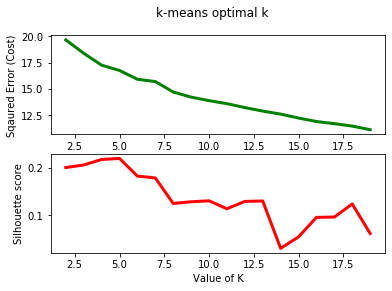

In [229]:
fig, axs = plt.subplots(2)
fig.suptitle('k-means optimal k')
axs[0].plot(range(2, 20), cost, color ='g', linewidth ='3')
axs[0].set_xlabel("Value of K") 
axs[0].set_ylabel("Sqaured Error (Cost)")
axs[1].plot(range(2, 20), score, color='r', linewidth = '3')
axs[1].set_xlabel("Value of K") 
axs[1].set_ylabel("Silhouette score")

In [230]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1])

In [231]:
df_DC_neigh2['KM Cluster Labels'] = kmeans.labels_
df_DC_neigh2.head()

,Neighborhood,Total Venues,E-scores,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes,KM Cluster Labels
0,16th Street Heights,15,2.708050,38.950315,-77.033559,78,4,74,2
1,Adams Morgan,56,3.852065,38.920472,-77.042391,473,39,434,2
2,American University Park,2,0.693147,38.947612,-77.090250,35,4,31,2
3,Arboretum,14,2.639057,38.914860,-76.972490,86,13,73,2
4,Barnaby Woods,4,1.386294,38.975433,-77.060174,36,0,36,2


In [232]:
df_DC_neigh3=df_DC_neigh2.reindex(columns= ['Neighborhood', 'Latitude','Longitude','Total Venues','E-scores','KM Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes'])
df_DC_neigh3.head(10)



,Neighborhood,Latitude,Longitude,Total Venues,E-scores,KM Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes
0,16th Street Heights,38.950315,-77.033559,15,2.708050,2,78,4,74
1,Adams Morgan,38.920472,-77.042391,56,3.852065,2,473,39,434
2,American University Park,38.947612,-77.090250,2,0.693147,2,35,4,31
3,Arboretum,38.914860,-76.972490,14,2.639057,2,86,13,73
4,Barnaby Woods,38.975433,-77.060174,4,1.386294,2,36,0,36
5,Barry Farm,38.859255,-76.997281,6,1.560710,2,119,40,79
6,Bellevue,38.826952,-77.009271,7,1.945910,2,151,45,106
7,Benning,38.891885,-76.948884,17,2.833213,2,307,55,252
8,Benning Ridge,38.881161,-76.938203,3,1.098612,2,110,32,78
9,Bloomingdale,38.918226,-77.011159,19,2.871476,2,321,40,281


In [233]:
df_DC_neigh3.describe()

,Latitude,Longitude,Total Venues,E-scores,KM Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,38.907798,-77.007464,19.604651,2.202020,1.837209,227.302326,29.503876,197.798450
std,0.033434,0.045369,22.977373,0.968114,0.596745,233.969837,29.548193,213.102285
min,38.826952,-77.103520,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,38.884788,-77.040984,5.000000,1.560710,2.000000,86.000000,7.000000,71.000000
50%,38.909556,-77.007767,9.000000,2.197225,2.000000,156.000000,23.000000,125.000000
75%,38.929808,-76.972490,25.000000,2.987771,2.000000,285.000000,45.000000,250.000000
max,38.982980,-76.917389,100.000000,4.034904,4.000000,1459.000000,178.000000,1281.000000


# Plot DC Neighborhood k-means Clusters.

In [234]:
# create map
map_clusters = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_DC_neigh3['Latitude'], df_DC_neigh3['Longitude'], df_DC_neigh3['Neighborhood'], df_DC_neigh3['KM Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore data relationships to predict DC neighborhood crime totals from venue features (Total Venues and Entropy score (E-score))

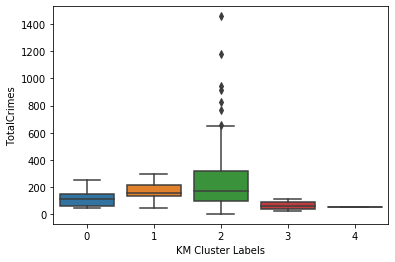

In [235]:
import seaborn as sns
sns.boxplot(x="KM Cluster Labels", y="TotalCrimes", data=df_DC_neigh3)

In [236]:
df_DC_neigh_clustergrouped = df_DC_neigh3.groupby('KM Cluster Labels').mean().reset_index()
df_DC_neigh_clustergrouped1 = df_DC_neigh_clustergrouped[['KM Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes']]
df_DC_neigh_clustergrouped1.columns = ['KM Cluster Label','Average Annual Crimes','Average Annual Violent Crimes','Average Annual Property Crimes']
df_DC_neigh_clustergrouped1.head()

,KM Cluster Label,Average Annual Crimes,Average Annual Violent Crimes,Average Annual Property Crimes
0,0,116.625000,27.500000,89.125000
1,1,165.100000,31.000000,134.100000
2,2,247.607477,30.149533,217.457944
3,3,64.666667,15.000000,49.666667
4,4,50.000000,5.000000,45.000000


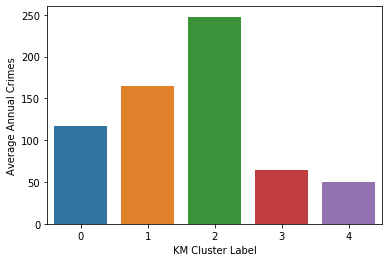

In [237]:
%matplotlib inline
ax = sns.barplot(x="KM Cluster Label", y="Average Annual Crimes", data=df_DC_neigh_clustergrouped1)

# Explore relationship between total venues, venue entropy score and total neighborhood crimes

(0, 1531.9166942604857)

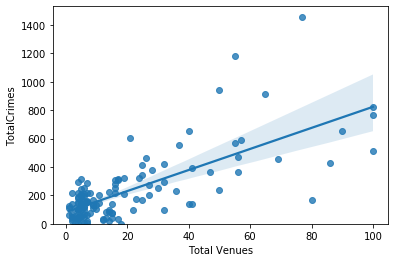

In [238]:
%matplotlib inline 
import seaborn as sns
sns.regplot(x="Total Venues", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

(0, 1540.4791363462043)

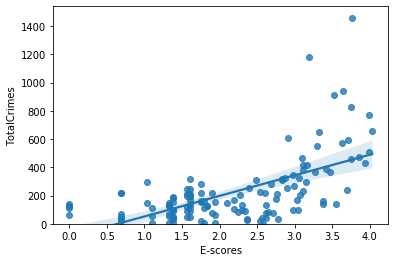

In [239]:
sns.regplot(x="E-scores", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

In [240]:
def PlotPolly(model, independent_variable, dependent_variable, Name, YName, Title):
    x_range = max(independent_variable)
    x_new = np.linspace(0, x_range, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title(Title)
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel(YName)

    plt.show()
    plt.close()

       3         2
23.64 x - 65.44 x + 43.12 x + 113.9


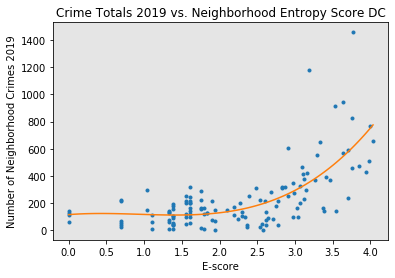

In [241]:
x = df_DC_neigh3['E-scores']
y = df_DC_neigh3['TotalCrimes']
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score DC')

log(y) =          3          2
0.04196 x + 0.1588 x - 0.5266 x + 6.641


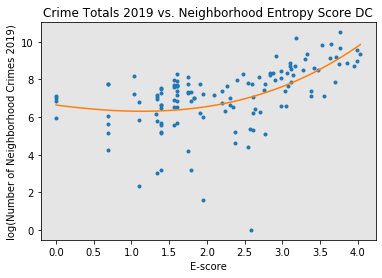

In [242]:
x = df_DC_neigh3['E-scores']
y = df_DC_neigh3['TotalCrimes']
logy = np.log2(y) 
f = np.polyfit(x, logy, 3)
p = np.poly1d(f)
print('log(y) =',p)
PlotPolly(p, x, logy, 'E-score', 'log(Number of Neighborhood Crimes 2019)', 'Crime Totals 2019 vs. Neighborhood Entropy Score DC')

# Use polynomial and multi-variate polynomial regression to predict for Total Crimes with features = 'Total Venues' and 'E-scores'

In [243]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
Z = df_DC_neigh3[['Total Venues', 'E-scores']]
Z1 = df_DC_neigh3[['E-scores']]
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=4, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(Z,y)
ypipe = pipe.predict(Z)
y1score = pipe.score(Z,y)
pipe.fit(Z1,y)
ypipe1 = pipe.predict(Z1)
y2score = pipe.score(Z1,y)
print (y1score, y2score)

0.6393649942366214 0.5108050222396727


In [244]:
df_DC_neigh4 = df_DC_neigh3
df_DC_neigh4['MVPolyFit_TotalCrimes'] = ypipe
df_DC_neigh4['PolyFit_TotalCrimes'] = ypipe1
df_DC_neigh4.head(10)

,Neighborhood,Latitude,Longitude,Total Venues,E-scores,KM Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes,MVPolyFit_TotalCrimes,PolyFit_TotalCrimes
0,16th Street Heights,38.950315,-77.033559,15,2.708050,2,78,4,74,218.080356,218.364999
1,Adams Morgan,38.920472,-77.042391,56,3.852065,2,473,39,434,362.068854,647.905001
2,American University Park,38.947612,-77.090250,2,0.693147,2,35,4,31,56.005149,156.390580
3,Arboretum,38.914860,-76.972490,14,2.639057,2,86,13,73,192.061252,201.502758
4,Barnaby Woods,38.975433,-77.060174,4,1.386294,2,36,0,36,114.561832,115.138064
5,Barry Farm,38.859255,-76.997281,6,1.560710,2,119,40,79,158.663420,106.784891
6,Bellevue,38.826952,-77.009271,7,1.945910,2,151,45,106,85.277911,106.957658
7,Benning,38.891885,-76.948884,17,2.833213,2,307,55,252,270.758485,252.318576
8,Benning Ridge,38.881161,-76.938203,3,1.098612,2,110,32,78,108.246142,134.460741
9,Bloomingdale,38.918226,-77.011159,19,2.871476,2,321,40,281,250.149082,263.539839


# Evaluate regression models using distribution plots

In [245]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Total Neighborhood Crimes 2019')
    plt.ylabel('Frequency')

    plt.show()
    plt.close()

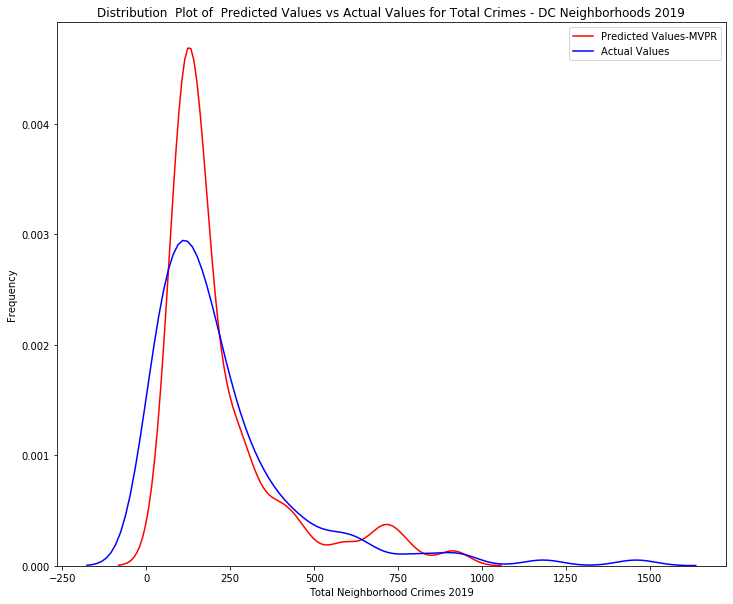

In [246]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = df_DC_neigh4['MVPolyFit_TotalCrimes']
y2 = df_DC_neigh4['TotalCrimes']
DistributionPlot(y1, y2, "Predicted Values-MVPR", "Actual Values", Title)

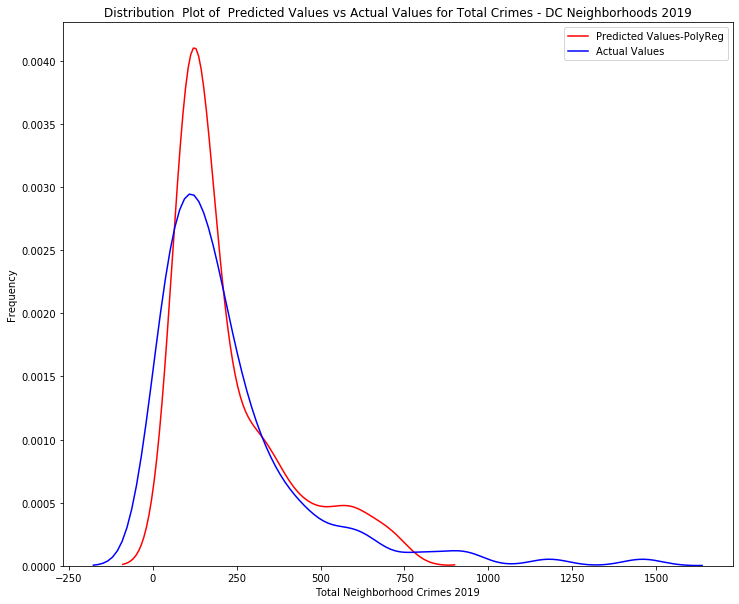

In [247]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = df_DC_neigh4['PolyFit_TotalCrimes']
y2 = df_DC_neigh4['TotalCrimes']
DistributionPlot(y1, y2, "Predicted Values-PolyReg", "Actual Values", Title)

# Load New York City Neighborhood and Crime Location Data

In [162]:
#Load NYC neighborhood labels and location data
df_NYCneigh_coords = pd.read_csv('NYC_neighborhoods.csv')
df_NYCneigh_coords.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [163]:
# Use Geopy to get the location of NYC"
address = 'New York City, New York'

geolocator = Nominatim(user_agent="NYCexplore")
location = geolocator.geocode(address)
NYClatitude = location.latitude
NYClongitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(NYClatitude, NYClongitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [164]:
#Load NYC crime data for 2019
df_NYCcrimes = pd.read_csv('New York Arrest Data_cleaned.csv')
df_NYCcrimes.head()

,Arrest Date,Offense Description,Latitude,Longitude
0,2019-01-01T00:00:00.000,CRIMINAL CONTEMPT 1,40.720432,-73.939701
1,2019-01-01T00:00:00.000,ASSAULT 3,40.861639,-73.927965
2,2019-01-01T00:00:00.000,"BURGLARY,UNCLASSIFIED,UNKNOWN",40.850288,-73.903871
3,2019-01-01T00:00:00.000,"TRAFFIC,UNCLASSIFIED MISDEMEAN",40.679981,-73.776234
4,2019-01-01T00:00:00.000,"PUBLIC ADMINISTRATION,UNCLASSI",40.511586,-74.249304


# Loop through NYC neighborhoods and count crimes

#Loop through each DC neighborhood and count the number of crime incidents in 2019 within a specified radius 
df_NYCneigh = df_NYCneigh_coords
radius = 500
TotalCrimes = []
for name,lat,long in zip(df_NYCneigh['Neighborhood'],df_NYCneigh['Latitude'],df_NYCneigh['Longitude']):
    crime_count = 0
    neigh_pt = (lat, long)
    print(name)
    for j, (crime_lat, crime_long) in enumerate(zip(df_NYCcrimes['Latitude'], df_NYCcrimes['Longitude'])):
            crime_pt = (crime_lat, crime_long)
            crime_dist = distance.distance(neigh_pt, crime_pt).meters
            if crime_dist <= radius:
                crime_count = crime_count + 1
    TotalCrimes.append(crime_count) 
df_NYCneigh['TotalCrimes'] = TotalCrimes
df_NYCneigh.head()

df_NYCneigh.to_csv('NYCneigh_crime_totals_2019.csv')

In [165]:
df_NYCneigh = pd.read_csv('NYCneigh_crime_totals_2019.csv')

In [166]:
df_NYCneigh.shape

(306, 6)

In [167]:
df_NYCneigh

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude,TotalCrimes
0,0,Bronx,Wakefield,40.894705,-73.847201,78
1,1,Bronx,Co-op City,40.874294,-73.829939,89
2,2,Bronx,Eastchester,40.887556,-73.827806,67
3,3,Bronx,Fieldston,40.895437,-73.905643,1
4,4,Bronx,Riverdale,40.890834,-73.912585,9
...,...,...,...,...,...,...
301,301,Manhattan,Hudson Yards,40.756658,-74.000111,369
302,302,Queens,Hammels,40.587338,-73.805530,106
303,303,Queens,Bayswater,40.611322,-73.765968,8
304,304,Queens,Queensbridge,40.756091,-73.945631,334


# Get NYC Neighborhood Venue Data from FourSquare 

In [168]:
df_NYC_venues = getNearbyVenues(names=df_NYCneigh['Neighborhood'],
                                   latitudes=df_NYCneigh['Latitude'],
                                   longitudes=df_NYCneigh['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [169]:
df_NYC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,4c537892fd2ea593cb077a28,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,4c783cef3badb1f7e4244b54,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,5d5f5044d0ae1c0008f043c3,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,4d6af9426107f04dedeb297a,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',4c25c212f1272d7f836385c5,40.890459,-73.849089,Donut Shop


In [170]:
df_NYC_venues.to_csv('NYC_Venues.csv')

# Process NYC Venue Data 

In [171]:
df_NYCneigh_totalvenues = pd.DataFrame(df_NYC_venues.groupby('Neighborhood').count())
df_NYCneigh_totalvenues.rename(columns = {'Venue':'Total Venues'}, inplace = True) 
df_NYCneigh_totalvenues.head()

,Neighborhood Latitude,Neighborhood Longitude,Total Venues,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Allerton,32,32,32,32,32,32,32
Annadale,13,13,13,13,13,13,13
Arden Heights,5,5,5,5,5,5,5
Arlington,4,4,4,4,4,4,4
Arrochar,21,21,21,21,21,21,21


In [172]:
df_NYC_neigh1 = pd.DataFrame(df_NYCneigh_totalvenues['Total Venues']).reset_index()
df_NYC_neigh1.head()

,Neighborhood,Total Venues
0,Allerton,32
1,Annadale,13
2,Arden Heights,5
3,Arlington,4
4,Arrochar,21


In [173]:
df_NYC_neigh1.shape

(299, 2)

In [174]:
# one hot encoding
NYC_onehot = pd.get_dummies(df_NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot['Neighborhood'] = df_NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
NYC_grouped_mean = NYC_onehot.groupby('Neighborhood').mean().reset_index()
print(NYC_grouped_mean.shape)
NYC_grouped_mean

(299, 432)


,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Woodhaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
295,Woodlawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
296,Woodrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
297,Woodside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0


In [176]:
NYC_grouped_sum = NYC_onehot.groupby('Neighborhood').sum().reset_index()
NYC_grouped_sum

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Arden Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Arrochar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Woodhaven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,Woodlawn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,Woodrow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,Woodside,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate NYC neighborhood venue entropy scores using NYC venue data grouped by venue category

In [177]:
NYC_grouped_temp = NYC_grouped_sum.drop('Neighborhood', 1)
E_scores = []
for index, row in NYC_grouped_temp.iterrows():
    Num_cats = row.sum()
    E_score = 0
    for x in row:
        if x > 0:
            E_score = E_score + -(x/Num_cats * math.log(x/Num_cats))
    E_scores.append(E_score)

df_NYC_neigh1['E-scores'] = E_scores #add the entropy scores as a column in the DC neighboorhoods dataframe
        
print(df_NYC_neigh1.shape)
df_NYC_neigh1.head()

(299, 3)


,Neighborhood,Total Venues,E-scores
0,Allerton,32,2.981301
1,Annadale,13,2.311423
2,Arden Heights,5,1.609438
3,Arlington,4,1.386294
4,Arrochar,21,2.689536


## Combine NYC venue data with NYC neighborhood crime data into one dataframe

In [178]:
df_NYC_neigh2 = pd.merge(df_NYC_neigh1, df_NYCneigh, on='Neighborhood', how='left')
print(df_NYC_neigh2.shape)
df_NYC_neigh2.head()

(303, 8)


,Neighborhood,Total Venues,E-scores,Unnamed: 0,Borough,Latitude,Longitude,TotalCrimes
0,Allerton,32,2.981301,298,Bronx,40.865788,-73.859319,211
1,Annadale,13,2.311423,215,Staten Island,40.538114,-74.178549,12
2,Arden Heights,5,1.609438,241,Staten Island,40.549286,-74.185887,19
3,Arlington,4,1.386294,227,Staten Island,40.635325,-74.165104,120
4,Arrochar,21,2.689536,228,Staten Island,40.596313,-74.067124,77


In [179]:
df_NYC_neigh2 = df_NYC_neigh2.drop(['Unnamed: 0'], 1)
df_NYC_neigh2.head()

,Neighborhood,Total Venues,E-scores,Borough,Latitude,Longitude,TotalCrimes
0,Allerton,32,2.981301,Bronx,40.865788,-73.859319,211
1,Annadale,13,2.311423,Staten Island,40.538114,-74.178549,12
2,Arden Heights,5,1.609438,Staten Island,40.549286,-74.185887,19
3,Arlington,4,1.386294,Staten Island,40.635325,-74.165104,120
4,Arrochar,21,2.689536,Staten Island,40.596313,-74.067124,77


# K-means cluster analysis on NYC neighhood venue categories

## Investigate the best value for K by using squared error and silhouette score

Text(0, 0.5, 'Silhouette score')

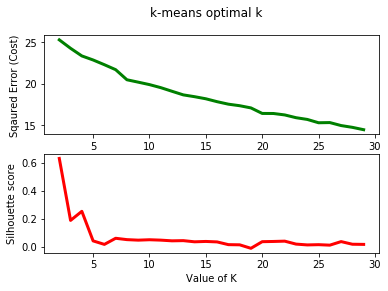

In [180]:
NYC_grouped_clustering = NYC_grouped_mean.drop('Neighborhood', 1)
cost =[] 
score = []
for i in range(2, 30): 
    KM = KMeans(n_clusters=i, random_state=0).fit(NYC_grouped_clustering) 
      
    # calculates squared error and silhouette score for the clustered points
        
    cost.append(KM.inertia_)
    score.append(metrics.silhouette_score(NYC_grouped_clustering, KM.labels_, metric='euclidean'))
    
fig, axs = plt.subplots(2)
fig.suptitle('k-means optimal k')
axs[0].plot(range(2, 30), cost, color ='g', linewidth ='3')
axs[0].set_xlabel("Value of K") 
axs[0].set_ylabel("Sqaured Error (Cost)")
axs[1].plot(range(2, 30), score, color='r', linewidth = '3')
axs[1].set_xlabel("Value of K") 
axs[1].set_ylabel("Silhouette score")

In [181]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 4,
       0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 4, 0, 2, 4, 4, 0, 0, 4, 0, 0,
       0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 3, 4, 0, 0, 4, 0, 4, 0, 4, 4, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 0, 0, 4, 4, 0, 0, 0,
       0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4,
       4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 0, 4,
       4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 4, 0,
       4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 4, 4, 0, 0, 0, 0, 4, 4,
       0, 0, 4, 4, 4, 4, 4, 4, 0, 1, 0, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0,
       0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4, 4,
       0, 3, 0, 0, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 4, 0, 4,
       0, 0, 0, 0, 0, 3, 4, 0, 4, 0, 0, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4,
       0, 0, 3, 4, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 0, 4, 0,
       4, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0])

In [182]:
df_NYC_grouped_neigh_clusters = pd.DataFrame(NYC_grouped_mean['Neighborhood'])
df_NYC_grouped_neigh_clusters['KM Cluster Labels'] = kmeans.labels_
print(df_NYC_grouped_neigh_clusters.shape)
df_NYC_grouped_neigh_clusters.head()

(299, 2)


,Neighborhood,KM Cluster Labels
0,Allerton,4
1,Annadale,4
2,Arden Heights,4
3,Arlington,0
4,Arrochar,0


In [183]:
df_NYC_neigh3 = pd.merge(df_NYC_neigh2, df_NYC_grouped_neigh_clusters, on='Neighborhood', how='left')
print(df_NYC_neigh3.shape)
df_NYC_neigh3.head(20)

(303, 8)


,Neighborhood,Total Venues,E-scores,Borough,Latitude,Longitude,TotalCrimes,KM Cluster Labels
0,Allerton,32,2.981301,Bronx,40.865788,-73.859319,211,4
1,Annadale,13,2.311423,Staten Island,40.538114,-74.178549,12,4
2,Arden Heights,5,1.609438,Staten Island,40.549286,-74.185887,19,4
3,Arlington,4,1.386294,Staten Island,40.635325,-74.165104,120,0
4,Arrochar,21,2.689536,Staten Island,40.596313,-74.067124,77,0
5,Arverne,20,2.579844,Queens,40.589144,-73.791992,166,0
6,Astoria,99,3.828976,Queens,40.768509,-73.915654,1295,0
7,Astoria Heights,15,2.615631,Queens,40.770317,-73.894680,71,4
8,Auburndale,19,2.871476,Queens,40.761730,-73.791762,32,0
9,Bath Beach,48,3.502825,Brooklyn,40.599519,-73.998752,605,4


In [184]:
df_NYC_neigh3.to_csv('NYC_neigh3.csv')

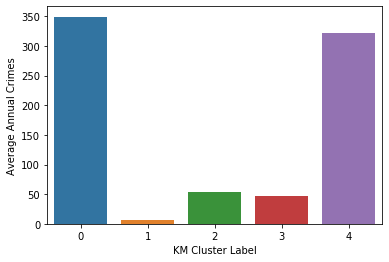

In [185]:
df_NYC_neigh3_clustergrouped = df_NYC_neigh3.groupby('KM Cluster Labels').mean().reset_index()
df_NYC_neigh3_clustergrouped1 = df_NYC_neigh3_clustergrouped[['KM Cluster Labels','TotalCrimes']]
df_NYC_neigh3_clustergrouped1.columns = ['KM Cluster Label','Average Annual Crimes']
ax = sns.barplot(x="KM Cluster Label", y="Average Annual Crimes", data=df_NYC_neigh3_clustergrouped1)

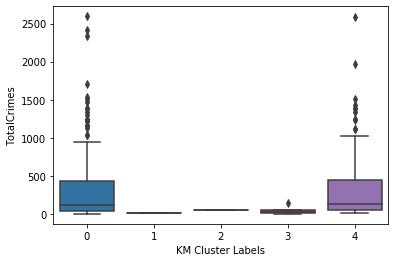

In [186]:
sns.boxplot(x="KM Cluster Labels", y="TotalCrimes", data=df_NYC_neigh3)

# Visualize NYC data with histogram, scatter plot, and preliminary polynomial fit

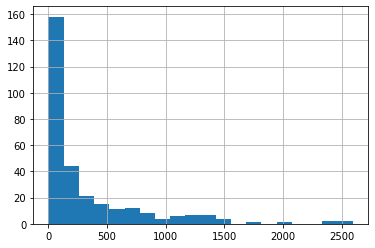

In [187]:
# Plot histogram of total neighborhood crimes for 2019
df_NYC_neigh3['TotalCrimes'].hist(bins = 20)


Model:        4         3         2
8.079 x - 43.75 x + 100.4 x - 38.5 x + 57.74


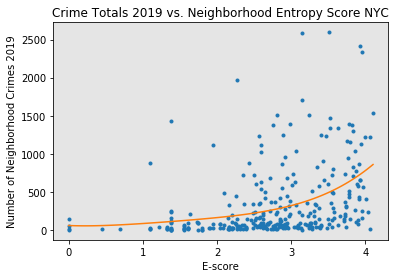

In [188]:
x = df_NYC_neigh3['E-scores']
y = df_NYC_neigh3['TotalCrimes']

f = np.polyfit(x, y, 4)
p = np.poly1d(f)
print('Model:', p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score NYC')

### Look at the data for one borough of NYC

In [189]:
df_NYC_neigh_cl1 = df_NYC_neigh3.loc[df_NYC_neigh3['Borough'] == 'Queens']
df_NYC_neigh_cl1.head()

,Neighborhood,Total Venues,E-scores,Borough,Latitude,Longitude,TotalCrimes,KM Cluster Labels
5,Arverne,20,2.579844,Queens,40.589144,-73.791992,166,0
6,Astoria,99,3.828976,Queens,40.768509,-73.915654,1295,0
7,Astoria Heights,15,2.615631,Queens,40.770317,-73.894680,71,4
8,Auburndale,19,2.871476,Queens,40.761730,-73.791762,32,0
12,Bay Terrace,45,3.278875,Queens,40.782843,-73.776802,12,0


Model:        4         3         2
10.08 x - 78.14 x + 245.5 x - 272.4 x + 94


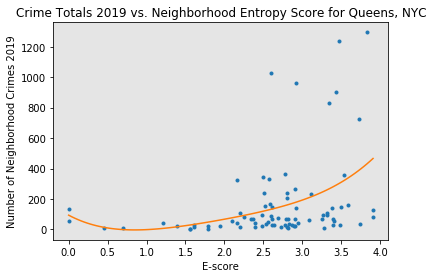

In [190]:
x = df_NYC_neigh_cl1['E-scores']
y = df_NYC_neigh_cl1['TotalCrimes']
f = np.polyfit(x, y, 4)
p = np.poly1d(f)
print('Model:', p)
PlotPolly(p, x, y, 'E-score', 'Number of Neighborhood Crimes 2019', 'Crime Totals 2019 vs. Neighborhood Entropy Score for Queens, NYC')

(0, 1377.561498344378)

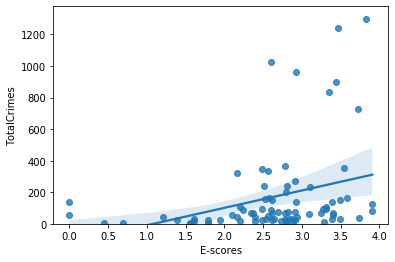

In [191]:
sns.regplot(x="E-scores", y="TotalCrimes", data=df_NYC_neigh_cl1)
plt.ylim(0,)

# Cluster analysis on NYC crime data using DBSCAN

In [192]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
Clus_dataSet = df_NYC_neigh3[['Total Venues','TotalCrimes','E-scores']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=6).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_NYC_neigh3["DBSCAN_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print(metrics.silhouette_score(Clus_dataSet, labels, metric='euclidean'))
print(labels)
print(clusterNum)
df_NYC_neigh3.head(10)

0.4063566396146151
[ 0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0 -1 -1 -1  0  0  0  0 -1
  0  0  0  0 -1  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  1  1  0  0
 -1  0 -1 -1 -1  0  0 -1  0  0  0  1  1  0  1  0  0 -1 -1  0  0  0  0  0
 -1  0  0 -1  0  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  0  0  0  0 -1 -1
  0  1  0  1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  1  0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0 -1  0
  0  0  0 -1  0  0  0  1  0  1  0 -1  0  0 -1 -1  0  0  0  0 -1 -1  0  0
  0  0  0 -1  0  0 -1 -1  0  0 -1  0  0  0  0  0 -1 -1 -1 -1 -1  0  0  0
  0  0 -1  0  0  1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  1  0  0  0 -1  0  0  0  0
  0  0  1 -1  1  0 -1  0  0  0 -1  0  1  0  0  1 -1  0  0  0  0 -1 -1  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
3


,Neighborhood,Total Venues,E-scores,Borough,Latitude,Longitude,TotalCrimes,KM Cluster Labels,DBSCAN_Labels
0,Allerton,32,2.981301,Bronx,40.865788,-73.859319,211,4,0
1,Annadale,13,2.311423,Staten Island,40.538114,-74.178549,12,4,0
2,Arden Heights,5,1.609438,Staten Island,40.549286,-74.185887,19,4,0
3,Arlington,4,1.386294,Staten Island,40.635325,-74.165104,120,0,0
4,Arrochar,21,2.689536,Staten Island,40.596313,-74.067124,77,0,0
5,Arverne,20,2.579844,Queens,40.589144,-73.791992,166,0,0
6,Astoria,99,3.828976,Queens,40.768509,-73.915654,1295,0,-1
7,Astoria Heights,15,2.615631,Queens,40.770317,-73.894680,71,4,0
8,Auburndale,19,2.871476,Queens,40.761730,-73.791762,32,0,0
9,Bath Beach,48,3.502825,Brooklyn,40.599519,-73.998752,605,4,-1


In [193]:
df_NYC_neigh3.to_csv('NYC_neigh3.csv')

In [194]:
df_NYC_neigh3.shape

(303, 9)

In [195]:
df_NYC_DBSCANgroups = pd.DataFrame(df_NYC_neigh3.groupby('DBSCAN_Labels').count())
df_NYC_DBSCANgroups[['KM Cluster Labels']].rename(columns={'KM Cluster Labels':'Number of Neighborhoods in Cluster'}).head()


,Number of Neighborhoods in Cluster
DBSCAN_Labels,
-1,59
0,223
1,21


In [196]:
# create map
map_clusters = folium.Map(location=[NYClatitude, NYClongitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_NYC_neigh3['Latitude'], df_NYC_neigh3['Longitude'], df_NYC_neigh3['Neighborhood'], df_NYC_neigh3['DBSCAN_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

     
map_clusters

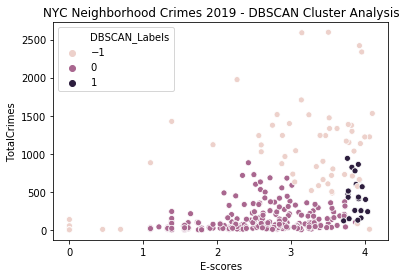

In [197]:
sns.scatterplot('E-scores', 'TotalCrimes', data=df_NYC_neigh3, hue='DBSCAN_Labels')
plt.title('NYC Neighborhood Crimes 2019 - DBSCAN Cluster Analysis')
plt.show()

Text(0.5, 0, 'DBSCAN Clusters')

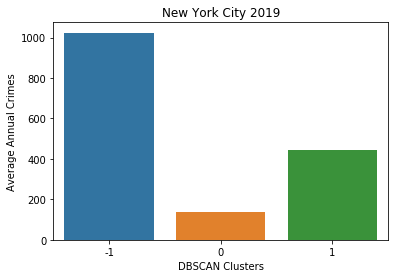

In [198]:
df_NYC_neigh3_clustergrouped = df_NYC_neigh3.groupby('DBSCAN_Labels').mean().reset_index()
df_NYC_neigh3_clustergrouped2 = df_NYC_neigh3_clustergrouped[['DBSCAN_Labels','TotalCrimes']]
df_NYC_neigh3_clustergrouped2.columns = ['DBSCAN_Labels','Average Annual Crimes']
ax = sns.barplot(x="DBSCAN_Labels", y="Average Annual Crimes", data=df_NYC_neigh3_clustergrouped2)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

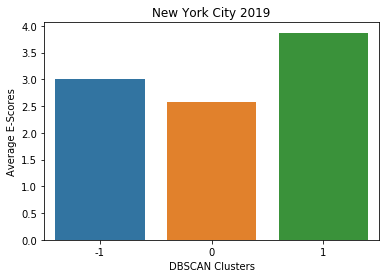

In [199]:
df_NYC_neigh3_clustergrouped3 = df_NYC_neigh3_clustergrouped[['DBSCAN_Labels','E-scores']]
df_NYC_neigh3_clustergrouped3.columns = ['DBSCAN_Labels','Average E-Scores']
ax = sns.barplot(x="DBSCAN_Labels", y="Average E-Scores", data=df_NYC_neigh3_clustergrouped3)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

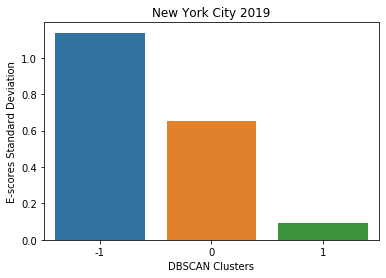

In [200]:
df_NYC_neigh3_clustergroupedSTD = df_NYC_neigh3.groupby('DBSCAN_Labels').std().reset_index()
df_NYC_neigh3_clustergrouped4 = df_NYC_neigh3_clustergroupedSTD[['DBSCAN_Labels','E-scores']]
df_NYC_neigh3_clustergrouped4.columns = ['DBSCAN_Labels','E-scores Standard Deviation']
ax = sns.barplot(x="DBSCAN_Labels", y="E-scores Standard Deviation", data=df_NYC_neigh3_clustergrouped4)
ax.set_title('New York City 2019')
ax.set_xlabel('DBSCAN Clusters')

# Cluster analysis on Washington DC crime data using DBSCAN¶

In [258]:
Clus_dataSet = df_DC_neigh3[['Total Venues','TotalCrimes','E-scores']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.35, min_samples=9).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_DC_neigh3["DBSCAN_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print(metrics.silhouette_score(Clus_dataSet, labels, metric='euclidean'))
print(labels)
print(realClusterNum)
df_DC_neigh3.head(10)

0.1360401587381896
[ 0 -1 -1  0  0  0  0  1  0  1  1 -1 -1  0  0  0 -1  0 -1 -1  0  0  0 -1
  0 -1  0 -1 -1  0  0 -1 -1 -1  0  0  0  0  0 -1 -1  0  0  0  1  0  0  0
  0  0 -1  0  0 -1 -1  0 -1 -1 -1  0  0  0  0  1 -1  0  0  0  0 -1  0  0
  1 -1 -1  0  0 -1  0  0  0 -1 -1 -1  0 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  0
  0 -1  0 -1  1  0 -1  0  0  0  0  0  0  0 -1  1 -1  0  0 -1 -1  0 -1  0
  0 -1  0  0 -1  0  0  0  0]
2


,Neighborhood,Latitude,Longitude,Total Venues,E-scores,KM Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes,MVPolyFit_TotalCrimes,PolyFit_TotalCrimes,DBSCAN_Labels
0,16th Street Heights,38.950315,-77.033559,15,2.708050,2,78,4,74,218.080356,218.364999,0
1,Adams Morgan,38.920472,-77.042391,56,3.852065,2,473,39,434,362.068854,647.905001,-1
2,American University Park,38.947612,-77.090250,2,0.693147,2,35,4,31,56.005149,156.390580,-1
3,Arboretum,38.914860,-76.972490,14,2.639057,2,86,13,73,192.061252,201.502758,0
4,Barnaby Woods,38.975433,-77.060174,4,1.386294,2,36,0,36,114.561832,115.138064,0
5,Barry Farm,38.859255,-76.997281,6,1.560710,2,119,40,79,158.663420,106.784891,0
6,Bellevue,38.826952,-77.009271,7,1.945910,2,151,45,106,85.277911,106.957658,0
7,Benning,38.891885,-76.948884,17,2.833213,2,307,55,252,270.758485,252.318576,1
8,Benning Ridge,38.881161,-76.938203,3,1.098612,2,110,32,78,108.246142,134.460741,0
9,Bloomingdale,38.918226,-77.011159,19,2.871476,2,321,40,281,250.149082,263.539839,1


In [259]:
df_DC_neigh3.to_csv('DC_neigh3.csv')

In [260]:
df_NYC_DBSCANgroups = pd.DataFrame(df_DC_neigh3.groupby('DBSCAN_Labels').count())
df_NYC_DBSCANgroups[['KM Cluster Labels']].rename(columns={'KM Cluster Labels':'Number of Neighborhoods in Cluster'}).head()


,Number of Neighborhoods in Cluster
DBSCAN_Labels,
-1,49
0,71
1,9


In [261]:
# create map
map_clusters = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_DC_neigh3['Latitude'], df_DC_neigh3['Longitude'], df_DC_neigh3['Neighborhood'], df_DC_neigh3['DBSCAN_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

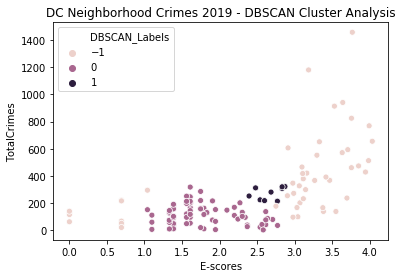

In [262]:
sns.scatterplot('E-scores', 'TotalCrimes', data=df_DC_neigh3, hue='DBSCAN_Labels')
plt.title('DC Neighborhood Crimes 2019 - DBSCAN Cluster Analysis')
plt.show()

Text(0.5, 0, 'DBSCAN Clusters')

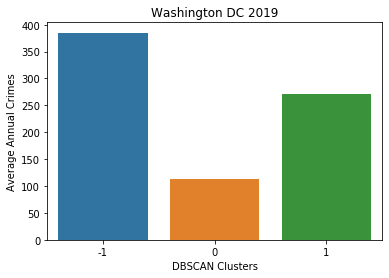

In [263]:
df_DC_neigh3_clustergrouped = df_DC_neigh3.groupby('DBSCAN_Labels').mean().reset_index()
df_DC_neigh3_clustergrouped2 = df_DC_neigh3_clustergrouped[['DBSCAN_Labels','TotalCrimes']]
df_DC_neigh3_clustergrouped2.columns = ['DBSCAN_Labels','Average Annual Crimes']
ax = sns.barplot(x="DBSCAN_Labels", y="Average Annual Crimes", data=df_DC_neigh3_clustergrouped2)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

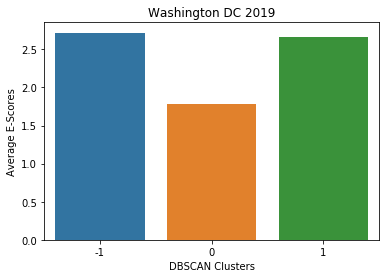

In [264]:
df_DC_neigh3_clustergrouped3 = df_DC_neigh3_clustergrouped[['DBSCAN_Labels','E-scores']]
df_DC_neigh3_clustergrouped3.columns = ['DBSCAN_Labels','Average E-Scores']
ax = sns.barplot(x="DBSCAN_Labels", y="Average E-Scores", data=df_DC_neigh3_clustergrouped3)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

Text(0.5, 0, 'DBSCAN Clusters')

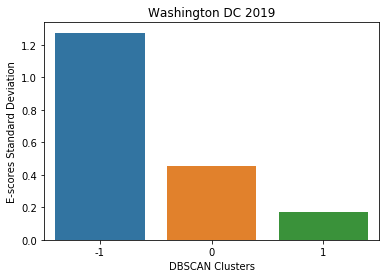

In [265]:
df_DC_neigh3_clustergroupedSTD = df_DC_neigh3.groupby('DBSCAN_Labels').std().reset_index()
df_DC_neigh3_clustergrouped4 = df_DC_neigh3_clustergroupedSTD[['DBSCAN_Labels','E-scores']]
df_DC_neigh3_clustergrouped4.columns = ['DBSCAN_Labels','E-scores Standard Deviation']
ax = sns.barplot(x="DBSCAN_Labels", y="E-scores Standard Deviation", data=df_DC_neigh3_clustergrouped4)
ax.set_title('Washington DC 2019')
ax.set_xlabel('DBSCAN Clusters')

# Use polynomial regression to predict total crimes using venue count and venue entropy score as features

## Polynomial regression on New York neighborhood data

In [354]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
X = df_NYC_neigh3[['Total Venues','E-scores']].values
y = df_NYC_neigh3['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=3, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)


R2 score = 0.055708859243689846


In [355]:
Rcross = cross_val_score(pipe, X, y, cv=4, scoring='r2')
Rcross.mean()

0.19135093075446377

In [357]:
y

array([211,  12,  19, 120,  77, 166,  71,  32, 135, 204,  12,  37, 111,
        39,  10,  22,  16,  18,  95,   2,  72,   3,  58,   1,  40, 251,
        24, 531, 156, 240, 600,  35, 235,  10,  70, 104, 469, 147, 202,
        32,   2,  26, 326, 716,  31,  83, 823, 157,  89, 400,  68,  52,
       486, 204,  35, 221, 187,  50,  21,  80,  96,  69, 129, 497, 409,
       284,  67, 149,  42,   7, 100, 365,  30,  29,   1, 776, 253, 655,
       141,   6, 109,  29, 101, 184, 239,  17,  34,  86,  25,  20,  15,
       306, 587,  82,  53,  52, 429,  24, 599, 151, 106, 146, 630, 128,
        18,  85,  24, 217,  31, 369,  38,  30, 356, 237,  97,  57,  40,
       378,  40, 269, 861,   0, 511,  33,  31, 148,  83,  29,  22, 104,
        10, 680,  12,  52,  62,  32,  45,  94,  53, 181, 447,  50, 726,
       684, 213,  37,  28, 420,  20, 346,  23, 256, 302,  33,  17, 352,
        59,  52, 334,  86,  62,  59, 442,  65,  74,  71,  14,  96, 159,
        94,  24, 314, 291,  77,  72, 334,  21, 231, 180,  92, 22

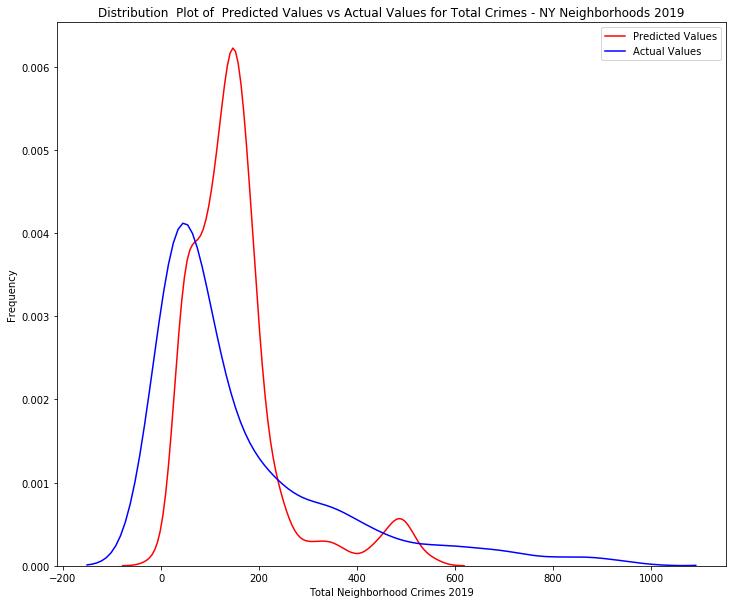

In [356]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

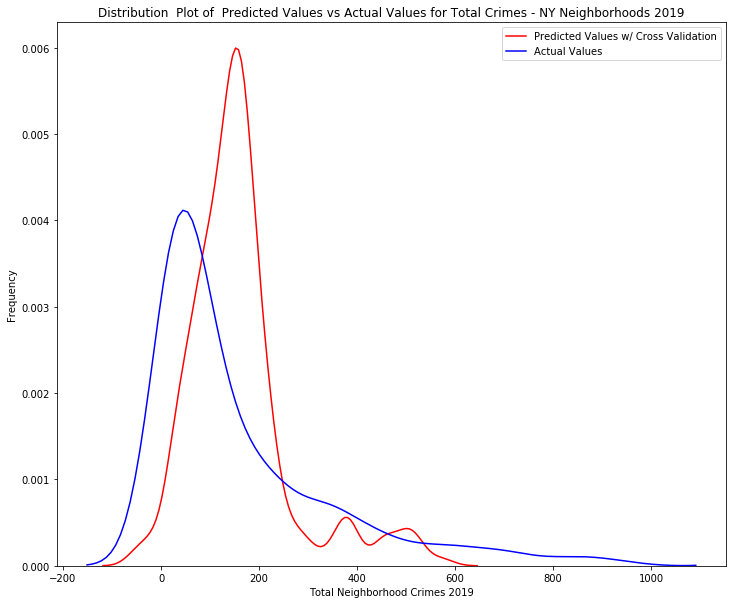

In [324]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = y
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Actual Values", Title)

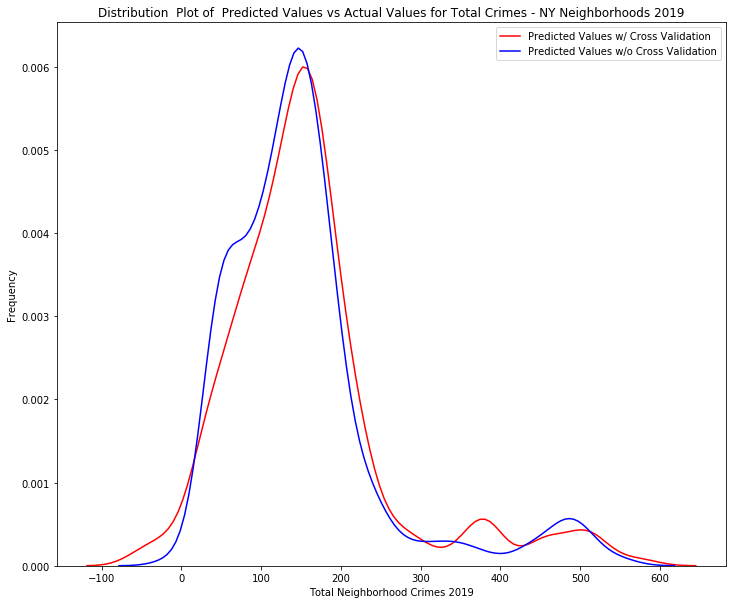

In [325]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = pipe.predict(X)
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Predicted Values w/o Cross Validation", Title)

In [271]:
df_NYC_neigh4 = df_NYC_neigh3
indexNames = df_NYC_neigh4[df_NYC_neigh4['DBSCAN_Labels'] == -1].index
df_NYC_neigh4.drop(indexNames , inplace=True)
print(df_NYC_neigh4.shape)
df_NYC_neigh4.head(100)

(244, 9)


,Neighborhood,Total Venues,E-scores,Borough,Latitude,Longitude,TotalCrimes,KM Cluster Labels,DBSCAN_Labels
0,Allerton,32,2.981301,Bronx,40.865788,-73.859319,211,4,0
1,Annadale,13,2.311423,Staten Island,40.538114,-74.178549,12,4,0
2,Arden Heights,5,1.609438,Staten Island,40.549286,-74.185887,19,4,0
3,Arlington,4,1.386294,Staten Island,40.635325,-74.165104,120,0,0
4,Arrochar,21,2.689536,Staten Island,40.596313,-74.067124,77,0,0
...,...,...,...,...,...,...,...,...,...
121,Great Kills,21,2.755550,Staten Island,40.549480,-74.149324,52,4,0
122,Greenpoint,100,3.777262,Brooklyn,40.730201,-73.954241,429,0,1
123,Greenridge,5,1.609438,Staten Island,40.555295,-74.170794,24,4,0
124,Greenwich Village,100,3.885347,Manhattan,40.726933,-73.999914,599,0,1


In [326]:
X = df_NYC_neigh4[['Total Venues','E-scores']].values
y = df_NYC_neigh4['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=3, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)

R2 score = 0.055708859243689846


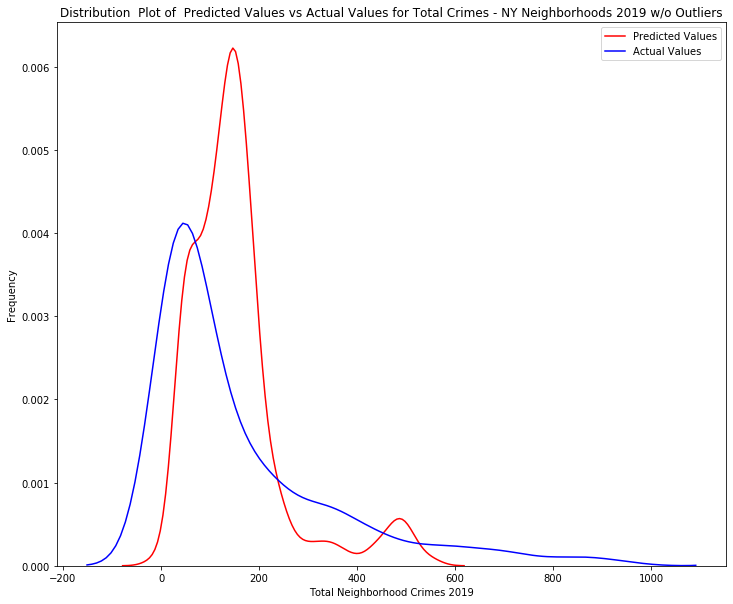

In [327]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019 w/o Outliers'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

## Polynomial regression on Washington DC neighborhood data

In [350]:
X = df_DC_neigh3[['Total Venues','E-scores']].values
y = df_DC_neigh3['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)

R2 score = 0.4946770886952748


In [351]:
Rcross = cross_val_score(pipe, X, y, cv=3, scoring='r2')
print(Rcross.mean())
Rcross

0.20491747951773423


array([ 0.4540088 ,  0.3614044 , -0.20066077])

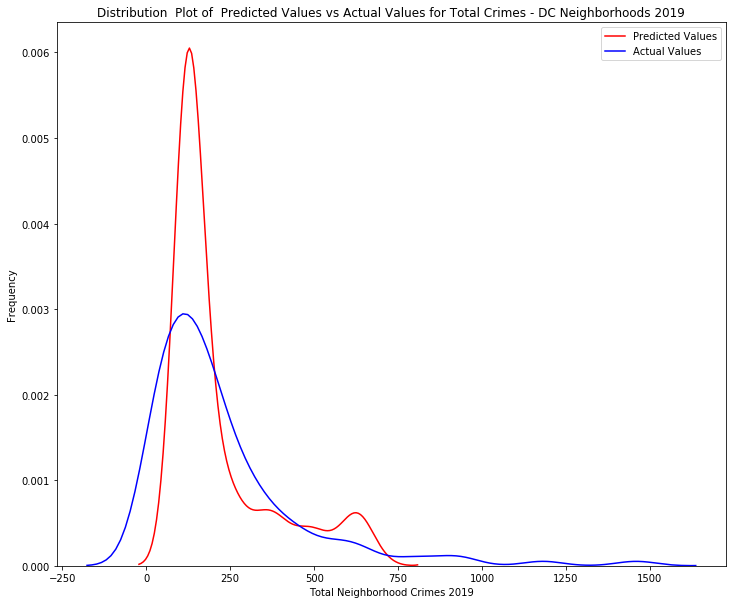

In [352]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)

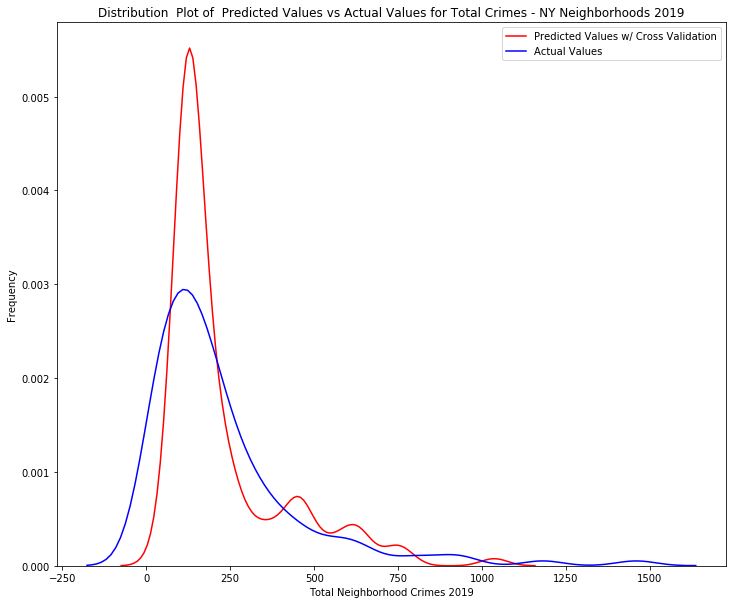

In [353]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - NY Neighborhoods 2019'
y1 = cross_val_predict(pipe,X, y,cv=4)
y2 = y
DistributionPlot(y1, y2, "Predicted Values w/ Cross Validation", "Actual Values", Title)

In [144]:
df_DC_neigh5 = df_DC_neigh3
indexNames = df_DC_neigh5[df_DC_neigh5['DBSCAN_Labels'] == -1].index
df_DC_neigh5.drop(indexNames , inplace=True)
print(df_DC_neigh5.shape)
df_DC_neigh5.head()

(96, 12)


,Neighborhood,Latitude,Longitude,Total Venues,E-scores,KM Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes,MVPolyFit_TotalCrimes,PolyFit_TotalCrimes,DBSCAN_Labels
0,16th Street Heights,38.950315,-77.033559,15,2.708050,1,78,4,74,218.080356,218.364999,0
2,American University Park,38.947612,-77.090250,2,0.693147,2,35,4,31,56.005149,156.390580,1
3,Arboretum,38.914860,-76.972490,14,2.639057,1,86,13,73,192.061252,201.502758,0
4,Barnaby Woods,38.975433,-77.060174,4,1.386294,6,36,0,36,114.561832,115.138064,0
5,Barry Farm,38.859255,-76.997281,6,1.560710,1,119,40,79,158.663420,106.784891,0


In [145]:
X = df_DC_neigh5[['Total Venues','E-scores']].values
y = df_DC_neigh5['TotalCrimes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=1, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train,y_train)
ypipe = pipe.predict(X_test)
y1score = pipe.score(X_test,y_test)
print ('R2 score =', y1score)


R2 score = 0.40117163375404197


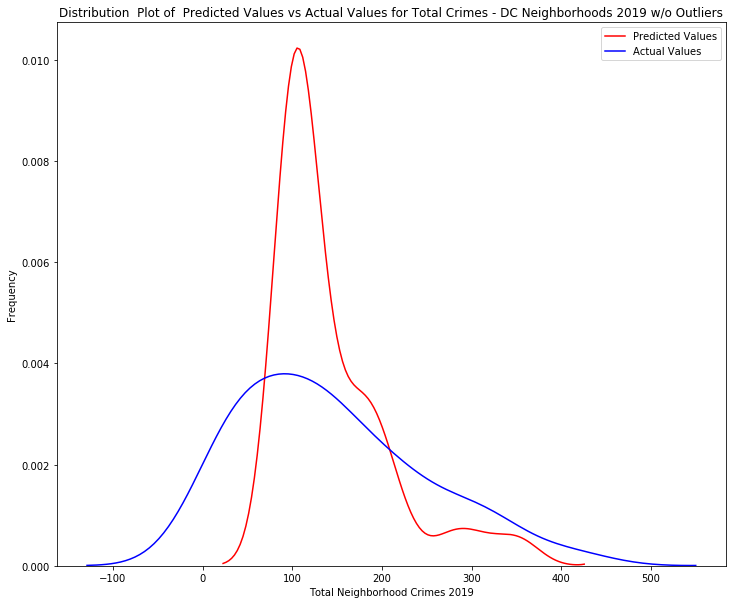

In [146]:
Title = 'Distribution  Plot of  Predicted Values vs Actual Values for Total Crimes - DC Neighborhoods 2019 w/o Outliers'
y1 = pipe.predict(X)
y2 = y
DistributionPlot(y1, y2, "Predicted Values", "Actual Values", Title)